In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.control.hybrid_benchmark.utils import feasible_mode_sequences
from pympc.plot import plot_input_sequence, plot_state_trajectory

In [149]:
# numeric parameters
m = 1.
d = .5
r = .1
eps = .5
h = .05
x_max = np.array([d-r, 5.])
x_min = - x_max
u_max = np.array([5.])
u_min = - u_max
xu_max = np.concatenate((x_max, u_max))
xu_min = np.concatenate((x_min, u_min))

In [150]:
# state and input symbolic
q, v= sp.symbols('q v')
x = sp.Matrix([q, v])
f = sp.symbols('f')
u = sp.Matrix([f])
xu = x.col_join(u)

In [151]:
# mode 1: no contact
v_next = v + h*f/m
q_next = q + h*v
x_next = sp.Matrix([q_next, v_next])
S1 = LinearSystem.from_symbolic(x, u, x_next)
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_symbolic_inequality(xu,sp.Matrix([q + v*h + - d + r,- q - v*h - d + r]))

In [152]:
# mode 2: contact with right wall
x_next = sp.Matrix([q, -eps*v])
S2 = AffineSystem.from_symbolic(x, u, x_next)
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_symbolic_inequality(xu,sp.Matrix([- q - v*h + d - r]))

In [153]:
# mode 3: contact with left wall
x_next = sp.Matrix([q, -eps*v])
S3 = AffineSystem.from_symbolic(x, u, x_next)
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_symbolic_inequality(xu,sp.Matrix([q + v*h + d - r]))

In [154]:
# piecewise affine system
S = PieceWiseAffineSystem([S1, S2, S3], [D1, D2, D3])
print 'Is well posed?', S.is_well_posed()

Is well posed? True


# Simulation

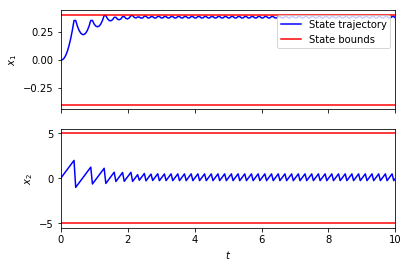

In [155]:
# push to the right wall with u=u_max
N_sim = 200
x0 = np.array([0., 0.])
x_sim, ms_sim = S.simulate(x0, [u_max]*N_sim)
plot_state_trajectory(x_sim, h, [x_min, x_max])

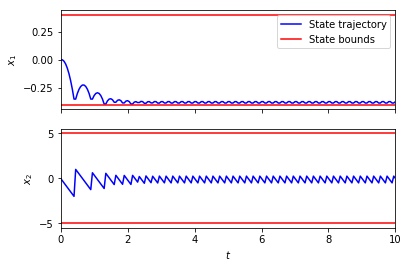

In [156]:
# push to the left wall with u=u_min
x_sim, ms_sim = S.simulate(x0, [u_min]*N_sim)
plot_state_trajectory(x_sim, h, [x_min, x_max])

# Solve MIQP with my branch and bound code

In [157]:
# controller parameters
N = 30
Q = np.eye(S.nx)
R = np.eye(S.nu)

# terminal set and cost
X_N = Polyhedron.from_bounds(*[np.zeros(S.nx)]*2)
P = np.zeros([S.nx]*2)

# hybrid MPC controller
method = 'CH'
norm = 'two'
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)

# initial conditions
x0 = np.array([0., 2.])

In [158]:
from pympc.control.hybrid_benchmark.branch_and_bound import branch_and_bound, best_first, breadth_first, depth_first
def solver(identifier, objective_cutoff):
    return controller.solve_relaxation(x0, identifier, objective_cutoff)
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
sol = branch_and_bound(
    solver,
    depth_first,
    controller.explore_in_chronological_order,
    tol=0.,
    tree_file_name='file_name'
)

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.010            1                -inf             inf             
  New incumbent    0.188            31               2.001            inf             
  New incumbent    0.487            103              2.001            40.142          
  Solution found   1.828            466              22.560           22.560          

Explored 466 nodes in 1.828 seconds: feasible solution found with objective 22.560.
The best lower bound is 22.560 (tolerance set to 0.000).


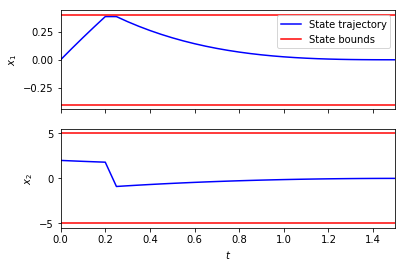

In [122]:
plot_state_trajectory(sol['state'], h, [x_min, x_max])

In [73]:
from pygraphviz import AGraph
from subprocess import call
from os import getcwd
graph = AGraph(directed=True, strict=True, filled=True)
graph.node_attr['style'] = 'filled'
graph.node_attr['fillcolor'] = 'white'
graph.add_node({'a':3})
graph.add_edge('a','c')

In [74]:
directory = getcwd() + '/' + 'file_name'
graph.write(directory + '.dot')
graph = AGraph(directory + '.dot')
graph.layout(prog='dot')
graph.draw(directory + '.pdf')

In [75]:
call(('open', directory + '.pdf'))

0

In [67]:
d = {'a':1, 'b':2}

In [68]:
str(d)

"{'a': 1, 'b': 2}"